In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
data = pd.read_csv("./Dataset/TSLA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


# Feature Engineering

### Relative Strength Index

In [ ]:
# Window length for moving average
window_length = 14

close = data['Adj Close']
# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

In [ ]:
# Calculate the RSI based on RMA/SMMA/MMA
# Reminder: Try to provide at least `window_length * 4` data points!
# Note: This should most closely match TradingView.
alpha = 1 / window_length
roll_up = up.ewm(alpha=alpha).mean()
roll_down = down.ewm(alpha=alpha).mean()
rs = roll_up / roll_down
rsi_rma = 100.0 - (100.0 / (1.0 + rs))

### Stochastic Oscillator and Williams %R

In [ ]:
high_14 = data['High'].rolling(14).max()
low_14 = data['Low'].rolling(14).min()
K = (data['Close'] - high_14)*100/(high_14 - low_14)
D = K.rolling(3).mean()
R = (high_14-data['Close'])*(-100)/(high_14 - low_14)

### Moving Average Convergence Divergence (MACD)

In [ ]:
exp1 = close.ewm(span=12, adjust=False).mean()
exp2 = close.ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
exp3 = macd.ewm(span=9, adjust=False).mean()

### Price Rate of Change

In [ ]:
# Computing 5-day rate of change
N = data['Close'].diff(5)
D = data['Close'].shift(5)
ROC = pd.Series(N/D,name='ROC')

### On Balance Volume

In [ ]:
OBV = []
OBV.append(0)
for i in range(1, len(data.Close)):
    if data.Close[i] > data.Close[i-1]: #If the closing price is above the prior close price 
          OBV.append(OBV[-1] + data.Volume[i]) #then: Current OBV = Previous OBV + Current Volume
    elif data.Close[i] < data.Close[i-1]:
          OBV.append( OBV[-1] - data.Volume[i])
    else:
          OBV.append(OBV[-1])

In [ ]:
#Store the OBV and OBV EMA into new columns
OBV = pd.Series(OBV, name='OBV')
OBV_EMA = OBV.ewm(com=20).mean()
# data['OBV_EMA'] = data['OBV'].ewm(com=20).mean()
#Show the data
OBV

0                0
1        -85935500
2       -127029500
3       -152728500
4       -187063000
           ...    
2974    5656694500
2975    5633512900
2976    5610732500
2977    5565354600
2978    5590939900
Name: OBV, Length: 2979, dtype: int64

### Rise and fall of stock price

In [ ]:
rise_fall = np.where(data['Close']-data['Close'].shift(1)>0, 1, 0)

### Features and train-test split

In [ ]:
features = pd.DataFrame(data={"RSI":rsi_rma, "SO":D, "WR":R, "MACD":macd, "ROC":ROC, "OBV":OBV_EMA})
target_df = pd.DataFrame(data={'3-day':data['Close'].shift(-3), '5-day':data['Close'].shift(-5), '7-day':data['Close'].shift(-7), '10-day':data['Close'].shift(-10), 'Change':rise_fall}).set_index(data['Date'])

In [ ]:
# Remove top 14 and last 10 rows to avoid NaN values
features = features.iloc[14:-10,:]
target_df = target_df.iloc[14:-10,:]
print('Features dataframe shape:', features.shape)
print('Target dataframe shape:', target_df.shape)

Features dataframe shape: (2955, 6)
Target dataframe shape: (2955, 5)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, target_df['10-day'].to_numpy(), test_size=0.3)
initSplit = TimeSeriesSplit(n_splits=2, test_size=int(0.3*len(features)))
trainDat, testDat = initSplit.split(features)
X_train, y_train = features[testDat[0]], target_df['3-day'].to_numpy()[testDat[0]]
X_test, y_test = features[testDat[1]], target_df['3-day'].to_numpy()[testDat[1]]
# print(trainDat[1][-1])
timeSplitCV = TimeSeriesSplit(n_splits=10)

# print(X_train.shape)
# print(X_test.shape)

# Regression

### [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [ ]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [1.79922063e-01 2.23798187e+02 3.28179991e-01 1.98691366e+00
 1.70224979e+00 5.61218530e+00]
Mean squared error: 6255.57
Mean Absolute Percentage error: 10.60
Mean Absolute error: 48.01
Coefficient of determination: 0.95


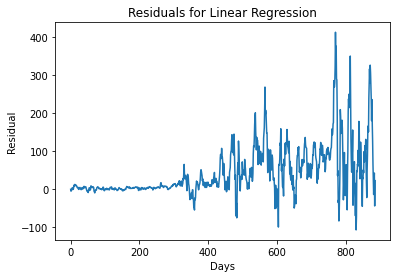

Mean of residuals: 42.98427425556414
Std of residuals: 66.39217434656474


In [ ]:
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Linear Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

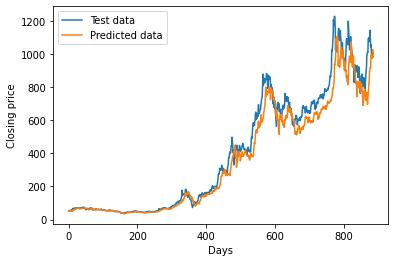

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

Coefficients: 
 [  0.25964421 202.57969028   0.30913638   3.55531622   1.55706538
   9.40990754]
Best Parameter:  {'alpha': 0.05623413251903491}
Mean squared error: 11066.43
Coefficient of determination: 0.91


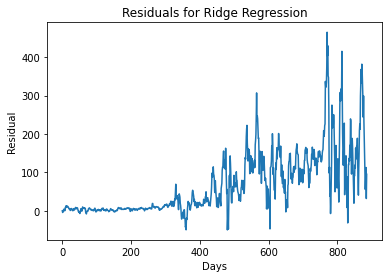

Mean of residuals: 66.79430317904601
Std of residuals: 81.27083740383368


In [ ]:
ridge_reg = linear_model.Ridge()
hyperparams = {'alpha': np.logspace(-3, 4, 5)}
ridge_dat = GridSearchCV(estimator=ridge_reg, param_grid=hyperparams, cv=timeSplitCV)
ridge_dat.fit(X_train, y_train)
y_pred = ridge_dat.predict(X_test)
print("Coefficients: \n", ridge_dat.best_estimator_.coef_)
print("Best Parameter: ", ridge_dat.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Ridge Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

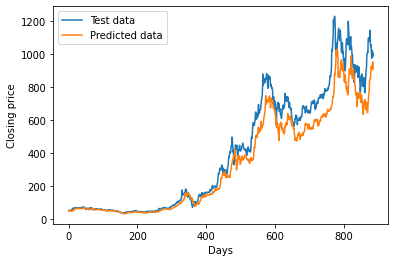

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Suppor Vector Machines

Mean squared error: 7227.32
Coefficient of determination: 0.94
Best parameters:  {'C': 1000.0, 'kernel': 'linear'}


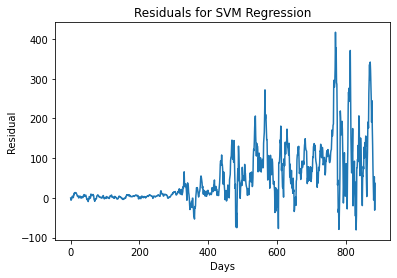

Mean of residuals: 48.91724493789593
Std of residuals: 69.53003904454447


In [ ]:
from sklearn import svm
svm_reg = svm.SVR()
hyperparams = {'C': np.logspace(-1, 3, 5), 'kernel': ['linear', 'rbf', 'sigmoid']}
svm_dat = GridSearchCV(estimator=svm_reg, param_grid=hyperparams, cv=timeSplitCV)
svm_dat.fit(X_train, y_train)
y_pred = svm_dat.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Best parameters: ", svm_dat.best_params_)
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for SVM Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

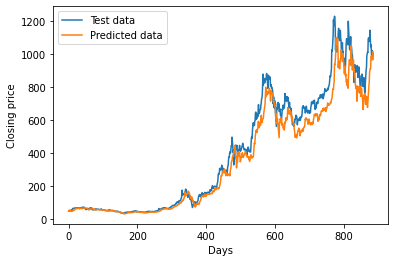

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [Bayesian Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge)
The priors over α and λ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called Bayesian Ridge Regression, and is similar to the classical Ridge.

Mean squared error: 6304.65
Coefficient of determination: 0.95
Best parameters:  {'alpha_1': 0.0001, 'alpha_2': 1e-08, 'lambda_1': 1e-08, 'lambda_2': 0.0001}


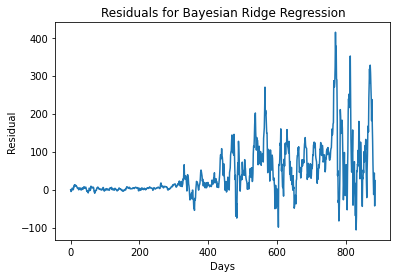

Mean of residuals: 43.30407238038094
Std of residuals: 66.55375990816405


In [ ]:
bayesian_reg = linear_model.BayesianRidge()
hyperparams = {'alpha_1': np.logspace(-8, -4, 5), 'alpha_2': np.logspace(-8, -4, 5), 'lambda_1': np.logspace(-8, -4, 5), 'lambda_2': np.logspace(-8, -4, 5)}
bayesian_dat = GridSearchCV(estimator=bayesian_reg, param_grid=hyperparams, cv=timeSplitCV)
bayesian_dat.fit(X_train, y_train)
y_pred = bayesian_dat.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Best parameters: ", bayesian_dat.best_params_)
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Bayesian Ridge Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

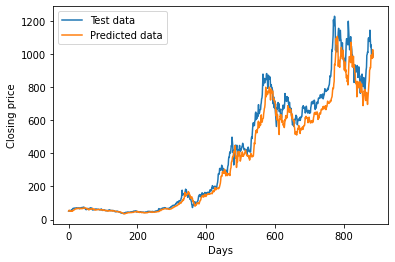

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [ElasticNet Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
Linear regression with combined L1 and L2 priors as regularizer.

/home/anand/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.611e+01, tolerance: 1.274e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/anand/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.031e+01, tolerance: 2.287e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the sol

/home/anand/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e+05, tolerance: 4.553e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/anand/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+05, tolerance: 5.322e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the sol

/home/anand/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e+05, tolerance: 4.553e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/anand/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.656e+05, tolerance: 5.322e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the sol

Mean squared error: 186093.40
Coefficient of determination: -0.47
Best parameters:  {'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 5000}


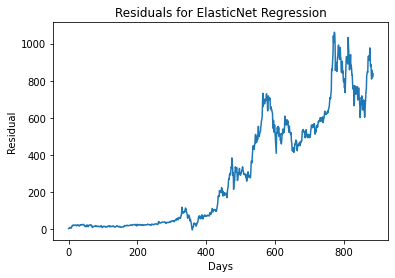

Mean of residuals: 304.3845587602106
Std of residuals: 305.68519492002486


In [ ]:
ElasticNet_reg = linear_model.ElasticNet()
hyperparams = {'l1_ratio': np.linspace(0, 1, 9), 'max_iter': [5000], 'alpha': np.logspace(-1, 3, 5)}
ElasticNet_dat = GridSearchCV(estimator=ElasticNet_reg, param_grid=hyperparams, cv=timeSplitCV)
ElasticNet_dat.fit(X_train, y_train)
y_pred = ElasticNet_dat.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Best parameters: ", ElasticNet_dat.best_params_)
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for ElasticNet Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

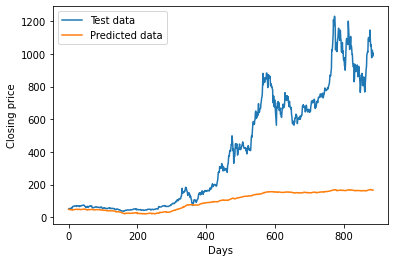

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### [Generalized Linear Regression Models](https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression)

#### [Poisson Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html#sklearn.linear_model.PoissonRegressor)
Generalized Linear Model with a Poisson distribution.

Mean squared error: 2621044.52
Mean Absolute Percentage error: 127.71
Mean Absolute error: 915.83
Coefficient of determination: -19.66


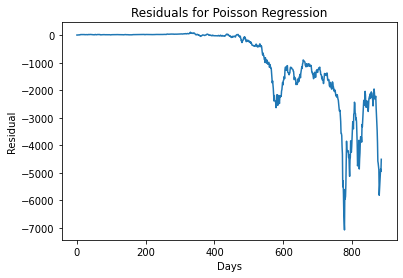

Mean of residuals: -890.268953787697
Std of residuals: 1352.2077176753664


In [ ]:
poisson_reg = linear_model.PoissonRegressor()
poisson_reg.fit(X_train, y_train)
y_pred = poisson_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Poisson Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

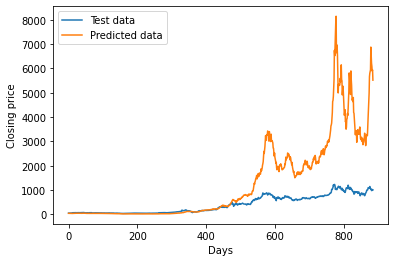

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

#### [Gamma Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.GammaRegressor.html#sklearn.linear_model.GammaRegressor)
Generalized Linear Model with a Gamma distribution. This regressor uses the ‘log’ link function.

Mean squared error: 233182.64
Mean Absolute Percentage error: 70.17
Mean Absolute error: 348.03
Coefficient of determination: -0.84


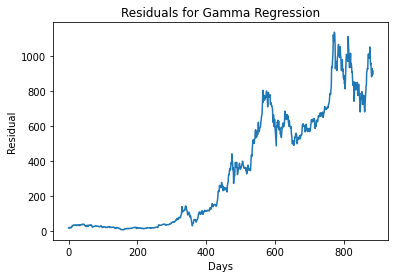

Mean of residuals: 348.0305109093813
Std of residuals: 334.7497640948524


In [ ]:
gamma_reg = linear_model.GammaRegressor()
gamma_reg.fit(X_train, y_train)
y_pred = gamma_reg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Gamma Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

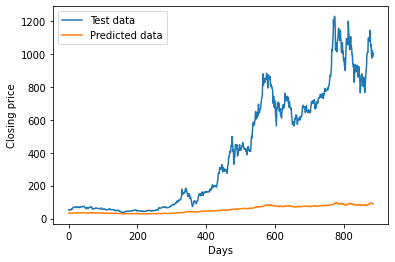

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Random Forest Regressor

Mean squared error: 238258.95
Mean Absolute Percentage error: 54.29
Mean Absolute error: 339.18
Coefficient of determination: -0.88


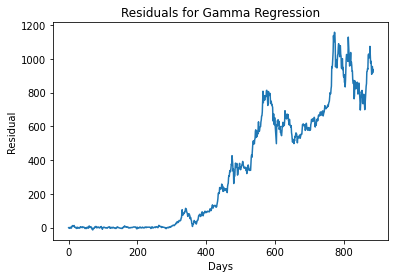

Mean of residuals: 338.5182349033973
Std of residuals: 351.65943112135005


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
y_pred = rfg.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Gamma Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

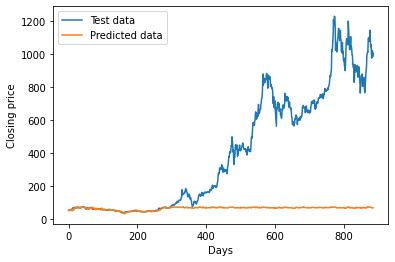

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### Xgboost regressor

/home/anand/.local/lib/python3.7/site-packages/pkg_resources/__init__.py:126: PkgResourcesDeprecationWarning: 0.18ubuntu0.18.04.1 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,
/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/base.py", line 706, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/home/anand/.local/lib/python3.7/site-p

/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/base.py", line 706, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 790, in r2_score
    y_true, y_pred, multioutput
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check

/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/base.py", line 706, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 790, in r2_score
    y_true, y_pred, multioutput
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check

/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/base.py", line 706, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 790, in r2_score
    y_true, y_pred, multioutput
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check

/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/base.py", line 706, in score
    return r2_score(y, y_pred, sample_weight=sample_weight)
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 790, in r2_score
    y_true, y_pred, multioutput
  File "/home/anand/.local/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 96, in _check_reg_targets
    y_pred = check

Mean squared error: 240329.61
Mean Absolute Percentage error: 55.12
Mean Absolute error: 341.29
Coefficient of determination: -0.89
Best hyperparameters:  {'learning_rate': 1.0, 'n_estimators': 10}


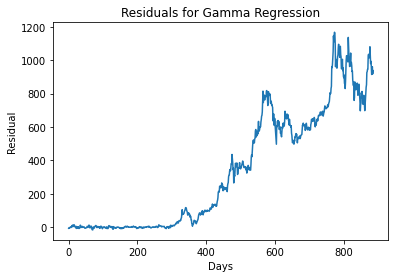

Mean of residuals: 340.0366438858238
Std of residuals: 353.1355092120565


In [ ]:
import xgboost as xg
xgb_r = xg.XGBRegressor()
hyperparams = {'n_estimators': [10, 25, 50], 'learning_rate': np.logspace(-2, 2, 5)}
xgb_data = GridSearchCV(estimator=xgb_r, param_grid=hyperparams, cv=timeSplitCV)
xgb_data.fit(X_train, y_train)
y_pred = xgb_data.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Best hyperparameters: ", xgb_data.best_params_)
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for Gamma Regression")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

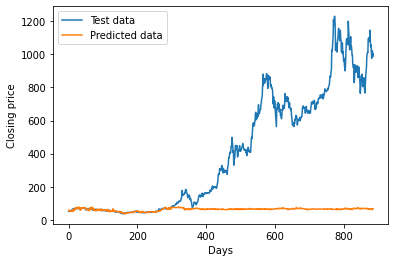

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test data', 'Predicted data'])
plt.xlabel("Days")
plt.ylabel("Closing price")
plt.show()

### LSTM Model

In [ ]:
import matplotlib.dates as mandates
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow import keras 
import tensorflow as tf

In [ ]:
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(features):
        X_train, X_test = features[:len(train_index)], features[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_df["5-day"][:len(train_index)].values.ravel(), target_df["5-day"][len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_train.shape

(2687, 6, 1)

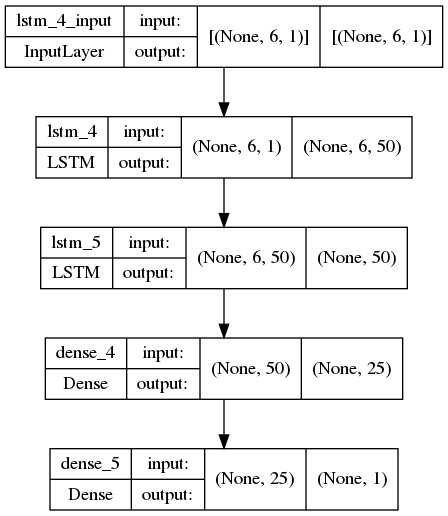

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1),activation='relu'))
model.add(LSTM(units=50,activation='relu'))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=60, batch_size=64, verbose=1)

Epoch 1/60
42/42 [==============================] - 0s 8ms/step - loss: 166.0031
Epoch 2/60
42/42 [==============================] - 0s 8ms/step - loss: 136.4644
Epoch 3/60
42/42 [==============================] - 0s 8ms/step - loss: 139.2249
Epoch 4/60
42/42 [==============================] - 0s 8ms/step - loss: 159.1728
Epoch 5/60
42/42 [==============================] - 0s 8ms/step - loss: 156.8456
Epoch 6/60
42/42 [==============================] - 0s 8ms/step - loss: 137.1845
Epoch 7/60
42/42 [==============================] - 0s 8ms/step - loss: 139.6435
Epoch 8/60
42/42 [==============================] - 0s 10ms/step - loss: 135.7804
Epoch 9/60
42/42 [==============================] - 0s 8ms/step - loss: 144.3309
Epoch 10/60
42/42 [==============================] - 0s 9ms/step - loss: 147.2728
Epoch 11/60
42/42 [==============================] - 0s 8ms/step - loss: 151.6991
Epoch 12/60
42/42 [==============================] - 0s 8ms/step - loss: 145.1859
Epoch 13/60
42/42 [=====

In [ ]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_pred = model.predict(X_test)
y_test = y_test.reshape(y_pred.shape)

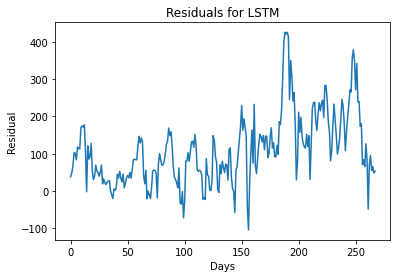

Mean of residuals: 109.75326627595905
Std of residuals: 94.42251308142441


In [ ]:
residual = y_test-y_pred
plt.plot([i for i in range(len(y_test))], residual)
plt.xlabel('Days')
plt.ylabel("Residual")
plt.title("Residuals for LSTM")
plt.show()
print("Mean of residuals:", residual.mean())
print("Std of residuals:", residual.std())

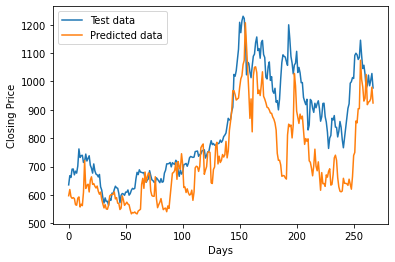

In [ ]:
plt.plot([i for i in range(len(y_test))], y_test)
plt.plot([i for i in range(len(y_test))], y_pred)
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend(['Test data', 'Predicted data'])
plt.show()

In [ ]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Percentage error: %.2f" % (100*mean_absolute_percentage_error(y_test, y_pred)))
print("Mean Absolute error: %.2f" % mean_absolute_error(y_test, y_pred))

Mean squared error: 20961.39
Coefficient of determination: 0.32
Mean Absolute Percentage error: 13.01
Mean Absolute error: 114.20


# Classification

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
X_train, X_test, y_train, y_test = train_test_split(features, target_df['Change'].to_numpy(), test_size=0.3)

### [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [ ]:
from sklearn import svm
clf = svm.SVC()
hyperparams = {'C': np.logspace(-1, 3, 5), 'kernel': ['linear', 'rbf', 'sigmoid']}
svc_dat = GridSearchCV(estimator=clf, param_grid=hyperparams, cv=timeSplitCV)
svc_dat.fit(X_train, y_train)
y_pred = svc_dat.predict(X_test)

In [ ]:
print("Confusion matrix:")
print("Best parameters: ", svc_dat.best_params_)
print(confusion_matrix(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Confusion matrix:
Best parameters:  {'C': 1000.0, 'kernel': 'rbf'}
[[290 147]
 [164 286]]
Accuracy score: 0.649379932356257
Recall score: 0.6355555555555555
F1 score: 0.6477916194790487


### [Stochastic Gradient Descent Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=100)
hyperparams = {'alpha': np.logspace(-5, -2, 5)}
sgd_dat = GridSearchCV(estimator=clf, param_grid=hyperparams, cv=timeSplitCV)
sgd_dat.fit(X_train, y_train)
y_pred = sgd_dat.predict(X_test)

In [ ]:
print("Confusion matrix:")
print("Best parameters: ", sgd_dat.best_params_)
print(confusion_matrix(y_test, y_pred))
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Confusion matrix:
Best parameters:  {'alpha': 0.01}
[[253 184]
 [147 303]]
Accuracy score: 0.6268320180383314
Recall score: 0.6733333333333333
F1 score: 0.6467449306296691


### [Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis().fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6245772266065389
Recall score: 0.6533333333333333
F1 score: 0.6384364820846906


### [KNN Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [ ]:
from sklearn import neighbors
for weights in ["uniform", "distance"]:
    clf = neighbors.KNeighborsClassifier(weights=weights)
    hyperparams = {'n_neighbors': [3, 5, 7, 10, 15]}
    knn_dat = GridSearchCV(estimator=clf, param_grid=hyperparams, cv=timeSplitCV)
    knn_dat.fit(X_train, y_train)
    y_pred = knn_dat.predict(X_test)
    print("For weights =", weights)
    print("Best parameters: ", knn_dat.best_params_)
    print("Accuracy score:", accuracy_score(y_test, y_pred))
    print("Recall score:",recall_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))
    print('-'*15)

For weights = uniform
Best parameters:  {'n_neighbors': 15}
Accuracy score: 0.6234498308906427
Recall score: 0.6244444444444445
F1 score: 0.6272321428571429
---------------
For weights = distance
Best parameters:  {'n_neighbors': 15}
Accuracy score: 0.6144306651634723
Recall score: 0.6044444444444445
F1 score: 0.6139954853273137
---------------


### [Gaussian Process Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [ ]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train, y_train)

In [ ]:
y_pred = gpc.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6505073280721533
Recall score: 0.6111111111111112
F1 score: 0.6395348837209301


### [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy score: 0.6065388951521984
Recall score: 0.6288888888888889
F1 score: 0.6185792349726776


### [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html)
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

#### [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
hyperparams = {'n_estimators': [7, 10, 15, 25]}
rfc_dat = GridSearchCV(estimator=clf, param_grid=hyperparams, cv=timeSplitCV)
rfc_dat.fit(X_train, y_train)
y_pred = rfc_dat.predict(X_test)
print("Best parameters: ", rfc_dat.best_params_)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Best parameters:  {'n_estimators': 15}
Accuracy score: 0.6223224351747464
Recall score: 0.6088888888888889
F1 score: 0.6206115515288789


#### [Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
print("Using SVC as base estimator")
clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print('-'*15)
print("Using DecisionTreeClassifier as base estimator")
clf = BaggingClassifier(base_estimator=None, n_estimators=10, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Using SVC as base estimator
Accuracy score: 0.649379932356257
Recall score: 0.5888888888888889
F1 score: 0.6302021403091558
---------------
Using DecisionTreeClassifier as base estimator
Accuracy score: 0.6414881623449831
Recall score: 0.5844444444444444
F1 score: 0.6232227488151658


### [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, learning_rate='adaptive', max_iter=10000).fit(X_train, y_train)
hyperparams = {'alpha': np.logspace(-5, -2, 6)}
mlp_dat = GridSearchCV(estimator=clf, param_grid=hyperparams, cv=timeSplitCV)
mlp_dat.fit(X_train, y_train)
y_pred = mlp_dat.predict(X_test)
print("Best parameters: ", mlp_dat.best_params_)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Best parameters:  {'alpha': 0.01}
Accuracy score: 0.6347237880496054
Recall score: 0.6066666666666667
F1 score: 0.6275862068965518


In [ ]:
clf = MLPClassifier(activation='identity', solver='lbfgs',random_state=1, max_iter=10000).fit(X_train, y_train)
hyperparams = {'alpha': np.logspace(-5, -2, 6)}
mlp_dat = GridSearchCV(estimator=clf, param_grid=hyperparams, cv=timeSplitCV)
mlp_dat.fit(X_train, y_train)
y_pred = mlp_dat.predict(X_test)
print("Best parameters: ", mlp_dat.best_params_)
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:",recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Best parameters:  {'alpha': 1e-05}
Accuracy score: 0.629086809470124
Recall score: 0.6555555555555556
F1 score: 0.6420021762785636


# Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# Read in the data
df = pd.read_csv('./Dataset/Stock News Dataset.csv', encoding = "ISO-8859-1")
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,2000-01-06,1,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,"Auntie back in fashion, even if the dress look...",Shoaib appeal goes to the top,Hussain hurt by 'shambles' but lays blame on e...,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for...,Christmas glitches,"Upending a table, Chopping a line and Scoring ...","Scientific evidence 'unreliable', defence claims",Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake-up of failing NHS,Lessons of law's hard heart
4,2000-01-07,1,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers: are you all whingers?,Hollywood Beyond,Ashes and diamonds,Whingers - a formidable minority,...,Most everywhere: UDIs,Most wanted: Chloe lunettes,Return of the cane 'completely off the agenda',From Sleepy Hollow to Greeneland,Blunkett outlines vision for over 11s,"Embattled Dobson attacks 'play now, pay later'...",Doom and the Dome,What is the north-south divide?,Aitken released from jail,Gone aloft


In [ ]:
traindf = df[df['Date'] < '20150101']
testdf = df[df['Date'] > '20141231']
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3975 entries, 0 to 3974
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    3975 non-null   object
 1   Label   3975 non-null   int64 
 2   Top1    3975 non-null   object
 3   Top2    3975 non-null   object
 4   Top3    3975 non-null   object
 5   Top4    3975 non-null   object
 6   Top5    3975 non-null   object
 7   Top6    3975 non-null   object
 8   Top7    3975 non-null   object
 9   Top8    3975 non-null   object
 10  Top9    3975 non-null   object
 11  Top10   3975 non-null   object
 12  Top11   3975 non-null   object
 13  Top12   3975 non-null   object
 14  Top13   3975 non-null   object
 15  Top14   3975 non-null   object
 16  Top15   3975 non-null   object
 17  Top16   3975 non-null   object
 18  Top17   3975 non-null   object
 19  Top18   3975 non-null   object
 20  Top19   3975 non-null   object
 21  Top20   3975 non-null   object
 22  Top21   3975 non-null   

In [ ]:
# Removing punctuations
headlinesdf= traindf.iloc[:,2:27]
headlinesdf.replace(to_replace="[^a-zA-Z]", value=" ", regex=True, inplace=True)
headlinesdf.columns= [str(i) for i in range(25)]
headlinesdf.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,A hindrance to operations extracts from the...,Scorecard,Hughes instant hit buoys Blues,Jack gets his skates on at ice cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar s debut double,Southgate strikes Leeds pay the penalty,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl s successor drawn into scandal,The difference between men and women,Sara Denver nurse turned solicitor,Diana s landmine crusade put Tories in a panic,Yeltsin s resignation caught opposition flat f...,Russian roulette,Sold out,Recovering a title
1,Scorecard,The best lake scene,Leader German sleaze inquiry,Cheerio boyo,The main recommendations,Has Cubie killed fees,Has Cubie killed fees,Has Cubie killed fees,Hopkins furious at Foster s lack of Hannibal...,Has Cubie killed fees,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man s extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn t know without the ...,Millennium bug fails to bite
2,Coventry caught on counter by Flo,United s rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,McGrath puts India out of their misery,Blair Witch bandwagon rolls on,...,South Melbourne Australia,Necaxa Mexico,Real Madrid Spain,Raja Casablanca Morocco,Corinthians Brazil,Tony s pet project,Al Nassr Saudi Arabia,Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,Auntie back in fashion even if the dress look...,Shoaib appeal goes to the top,Hussain hurt by shambles but lays blame on e...,England s decade of disasters,Revenge is sweet for jubilant Cronje,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for,Christmas glitches,Upending a table Chopping a line and Scoring ...,Scientific evidence unreliable defence claims,Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake up of failing NHS,Lessons of law s hard heart
4,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers are you all whingers,Hollywood Beyond,Ashes and diamonds,Whingers a formidable minority,Alan Parker part two,Thuggery Toxins and Ties,...,Most everywhere UDIs,Most wanted Chloe lunettes,Return of the cane completely off the agenda,From Sleepy Hollow to Greeneland,Blunkett outlines vision for over s,Embattled Dobson attacks play now pay later ...,Doom and the Dome,What is the north south divide,Aitken released from jail,Gone aloft


In [ ]:
headlines = []
for row in range(0,len(headlinesdf.index)):
    headlines.append(' '.join(str(x).lower() for x in headlinesdf.iloc[row,0:25]))
headlines[0]

'a  hindrance to operations   extracts from the leaked reports scorecard hughes  instant hit buoys blues jack gets his skates on at ice cold alex chaos as maracana builds up for united depleted leicester prevail as elliott spoils everton s party hungry spurs sense rich pickings gunners so wide of an easy target derby raise a glass to strupar s debut double southgate strikes  leeds pay the penalty hammers hand robson a youthful lesson saints party like it s      wear wolves have turned into lambs stump mike catches testy gough s taunt langer escapes to hit     flintoff injury piles on woe for england hunters threaten jospin with new battle of the somme kohl s successor drawn into scandal the difference between men and women sara denver  nurse turned solicitor diana s landmine crusade put tories in a panic yeltsin s resignation caught opposition flat footed russian roulette sold out recovering a title'

In [ ]:
#tokenize the word data
vectorizer = CountVectorizer(ngram_range=(2,2))
train_data = vectorizer.fit_transform(headlines)

In [ ]:
#initialise the base model
model = LogisticRegression()
model = model.fit(train_data, traindf["Label"])

In [ ]:
testheadlines = []
for row in range(0,len(testdf.index)):
    testheadlines.append(' '.join(str(x) for x in testdf.iloc[row,2:27]))
test_data = vectorizer.transform(testheadlines)
predictions = model.predict(test_data)

In [ ]:
pd.crosstab(testdf["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,159,27
1,27,165


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

print(classification_report(testdf["Label"], predictions))
print(accuracy_score(testdf["Label"], predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       186
           1       0.86      0.86      0.86       192

    accuracy                           0.86       378
   macro avg       0.86      0.86      0.86       378
weighted avg       0.86      0.86      0.86       378

0.8571428571428571
